In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, cross_val_predict
from sklearn.metrics import median_absolute_error, accuracy_score, r2_score, PredictionErrorDisplay
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


Topics<br>
-Linear regression, decision tree, random forest,lbgm, XBGregressor <br>
-cross validation<br>
-pipepline, transformers, column_transformer<br>
-gridsearch, randomizedsearch<br>
-median_absolute_error, r2_score, l1, l2

In [2]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 4


# Explore dataset

In [3]:
data = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv").drop('id', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [4]:
data.columns

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>,
        <Axes: title={'center': 'Hardness'}>]], dtype=object)

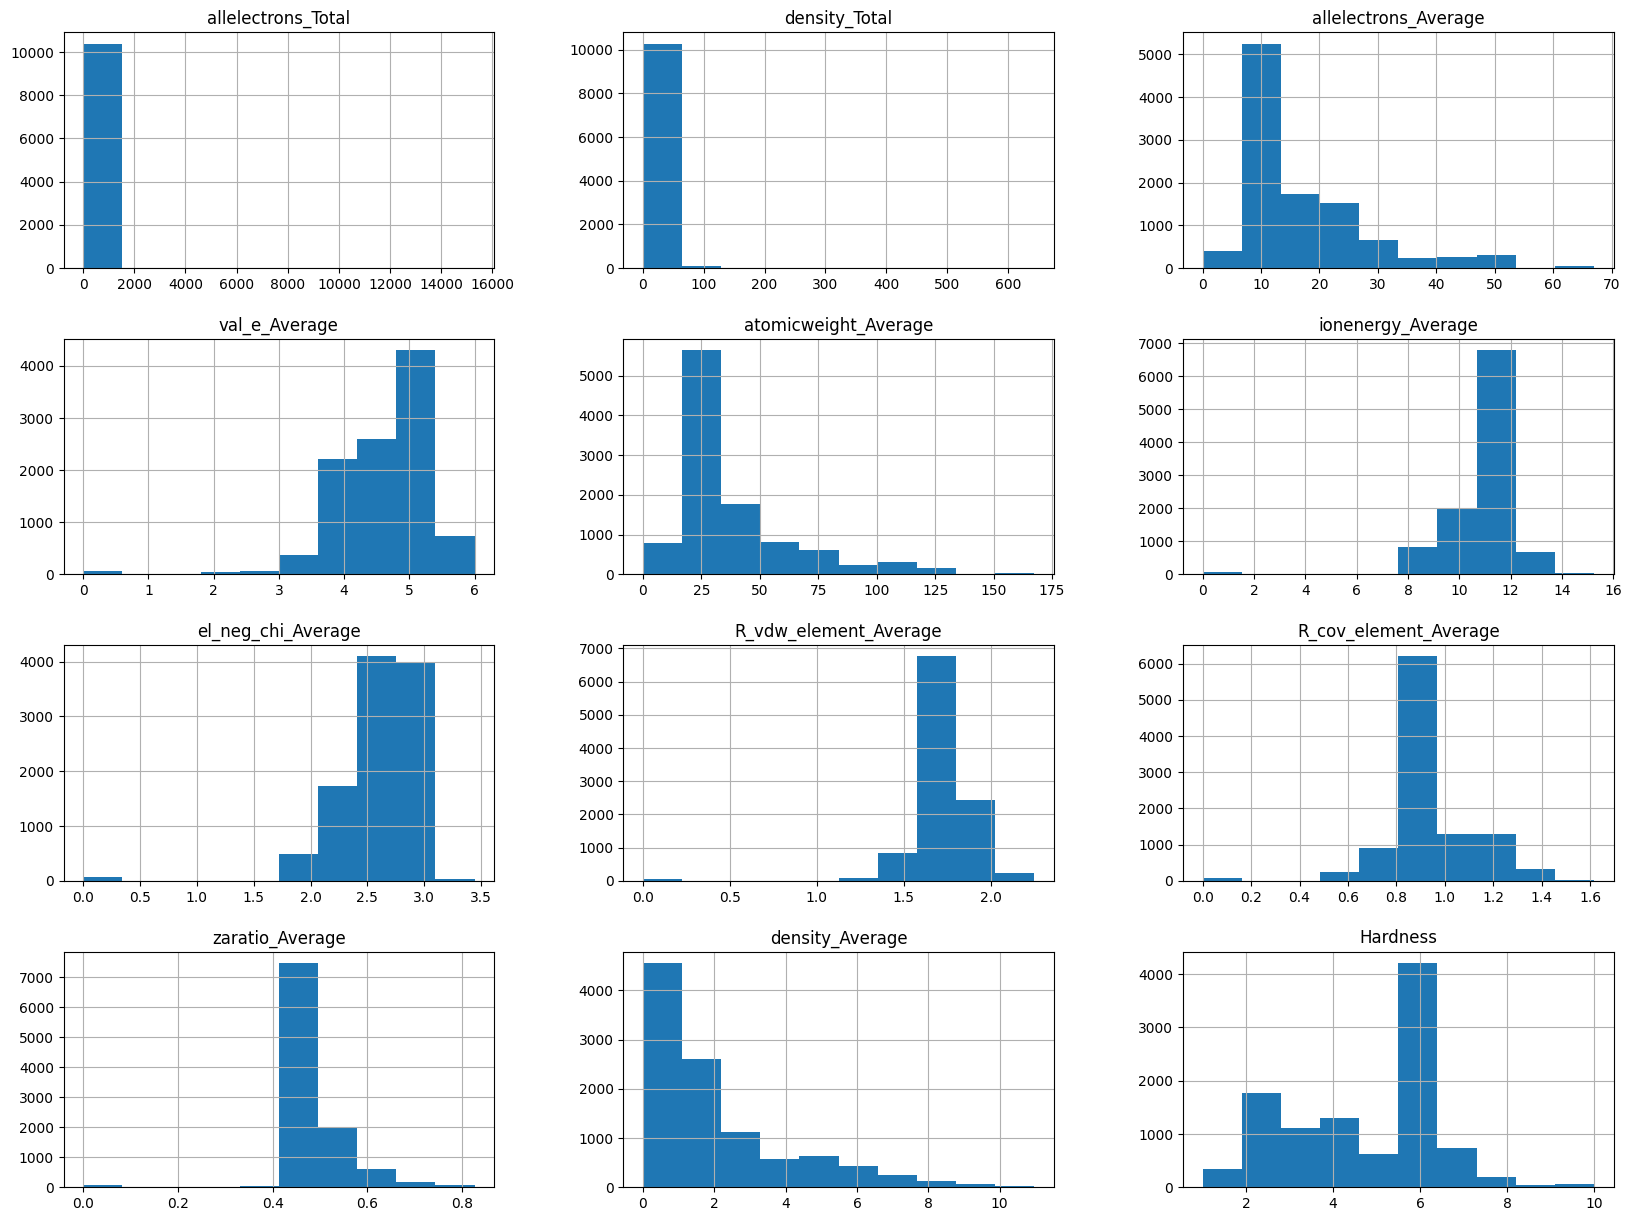

In [5]:
data.hist(figsize=(20, 15))

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840
zaratio_Average,10407.0,0.493349,0.063080,0.0,0.476196,0.488550,0.496070,0.825990


<Axes: >

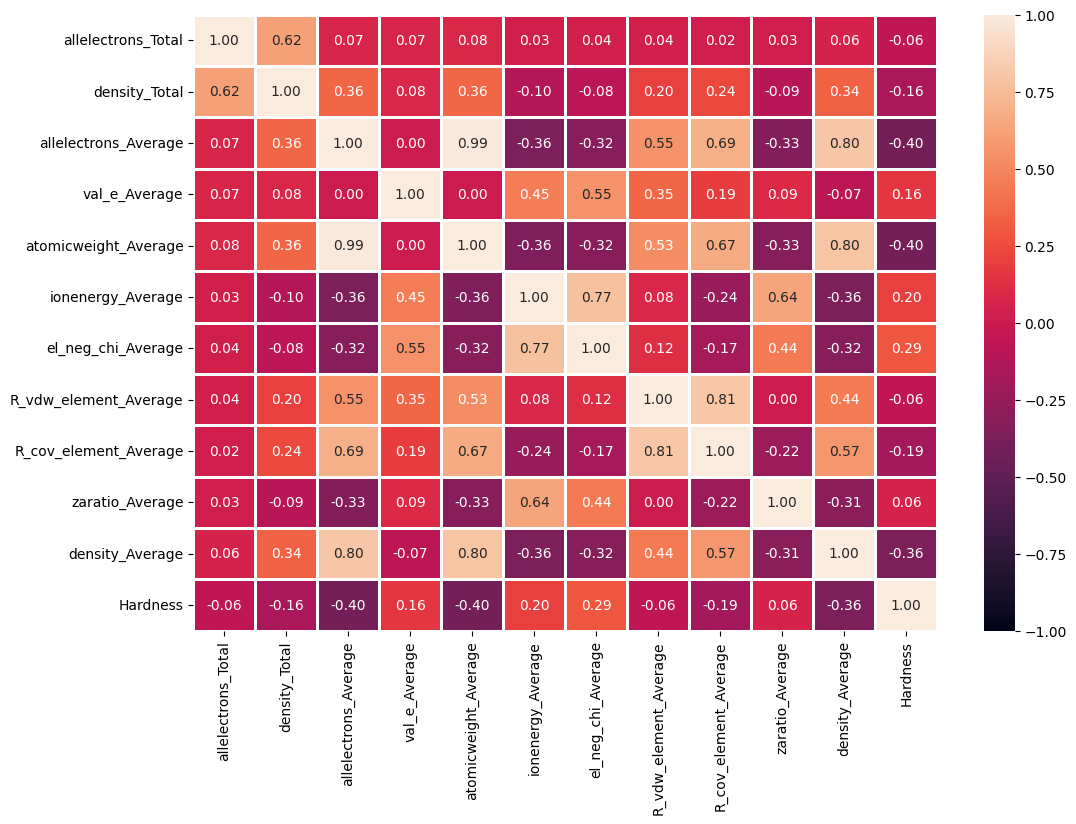

In [7]:
correlaction_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlaction_matrix, annot=True, vmin=-1, vmax=1, linewidths=1, fmt="0.2f")

Atomicweight_Average and allelectrons_Average are highly corellated with each other. Let's drop one of them.

In [8]:
#keep csv data format, we can use it directly in column transformer to preporocess values
X = data.drop(columns=['Hardness', 'atomicweight_Average'], axis = 1)
y = data['Hardness']



X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.80, random_state=7)


array([[<Axes: title={'center': 'pipeline-1__allelectrons_Total'}>,
        <Axes: title={'center': 'pipeline-1__density_Total'}>,
        <Axes: title={'center': 'pipeline-1__allelectrons_Average'}>],
       [<Axes: title={'center': 'pipeline-1__val_e_Average'}>,
        <Axes: title={'center': 'pipeline-1__ionenergy_Average'}>,
        <Axes: title={'center': 'pipeline-1__el_neg_chi_Average'}>],
       [<Axes: title={'center': 'pipeline-1__R_vdw_element_Average'}>,
        <Axes: title={'center': 'pipeline-1__R_cov_element_Average'}>,
        <Axes: title={'center': 'pipeline-1__zaratio_Average'}>],
       [<Axes: title={'center': 'pipeline-1__density_Average'}>,
        <Axes: >, <Axes: >]], dtype=object)

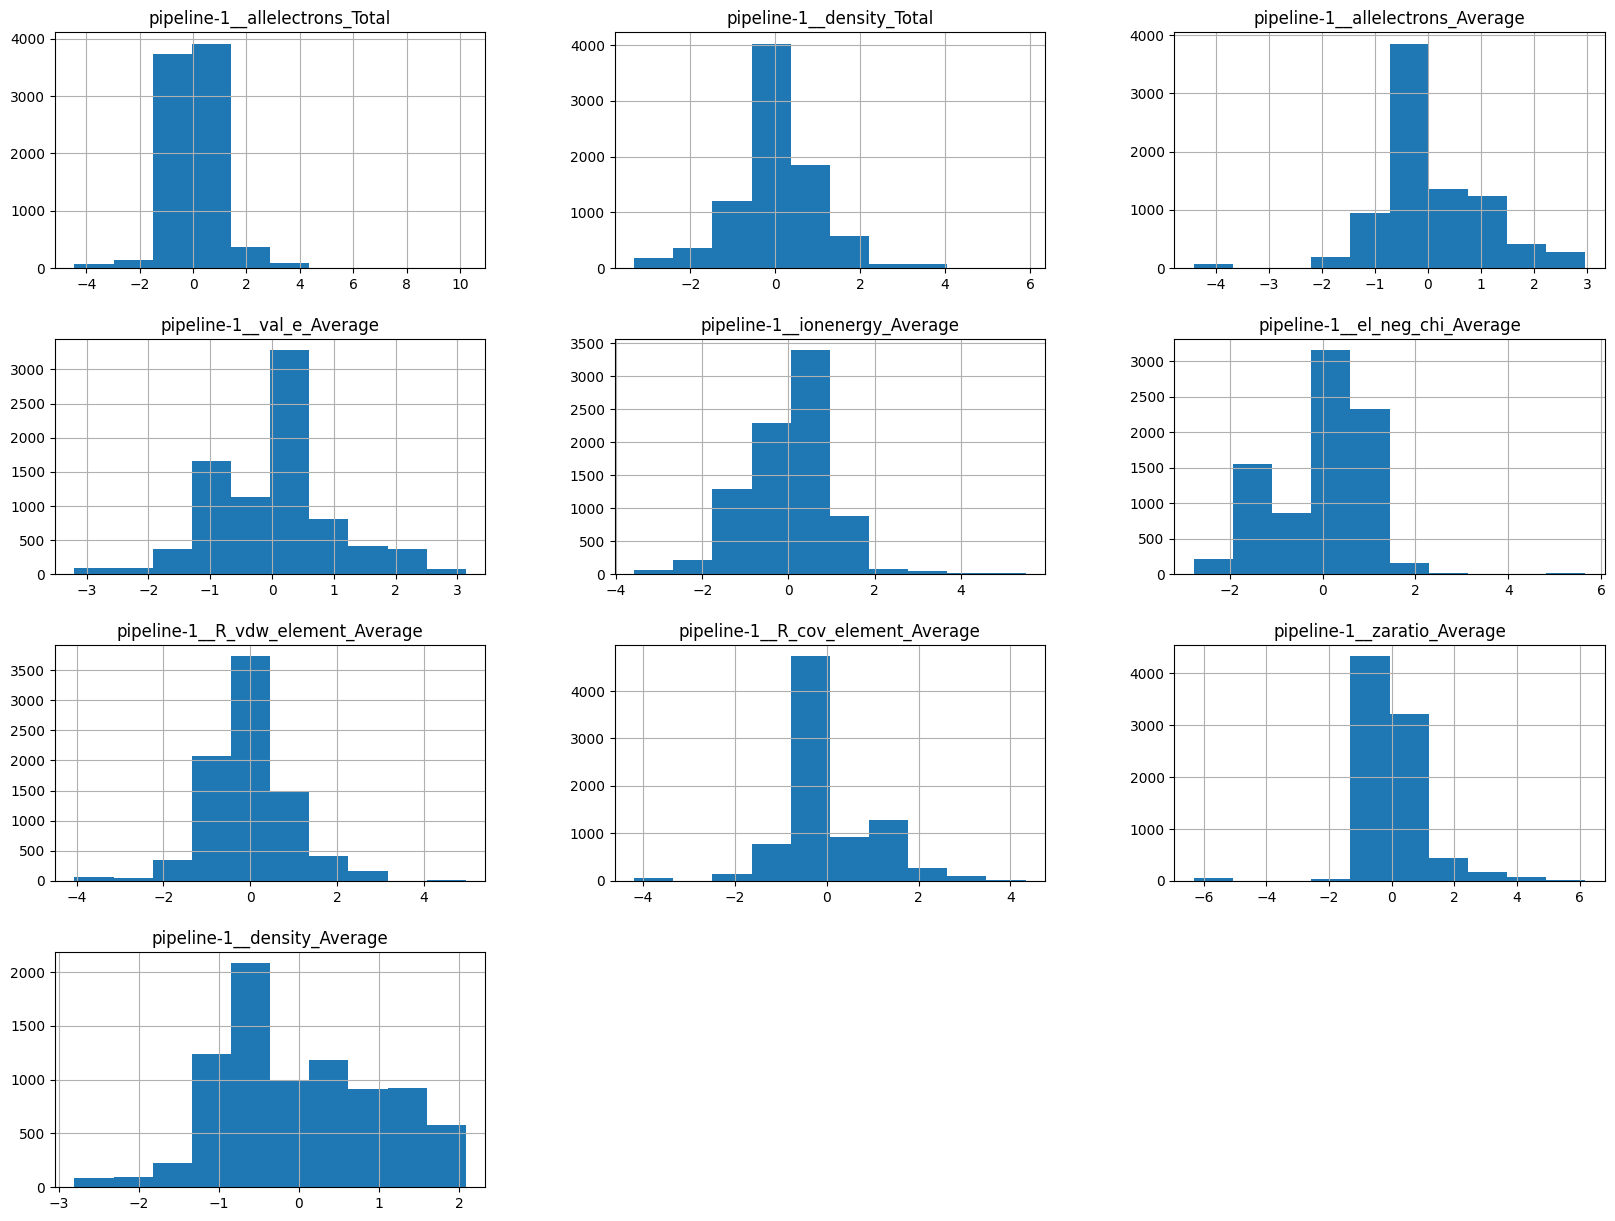

In [9]:
transformer = make_pipeline(PowerTransformer(method='yeo-johnson'))
#transformer = make_pipeline(RobustScaler())
#transformer = make_pipeline(StandardScaler())

quant_transformer = make_pipeline(QuantileTransformer())

preprocessor = make_column_transformer(
    (transformer, ['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average','ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average']),
    (quant_transformer, [])


).set_output(transform="pandas")

X_out = preprocessor.fit(X_train)
X_transformed = X_out.transform(X_train)
X_transformed.hist(figsize=(20, 15))

In [10]:
results = []

# Testing models

In [11]:
skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 7)

processor = make_column_transformer((transformer, ['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average','ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average']),remainder="passthrough")
lr = linear_model.LinearRegression()
pipe = make_pipeline(processor, lr)
cv_res = cross_validate(estimator=pipe, X=X, y=y, cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
results.append(['Linear regression', mae, r2])

1.0928009097058335 0.16244947465377937


1.093800691579237 0.16246272256406846


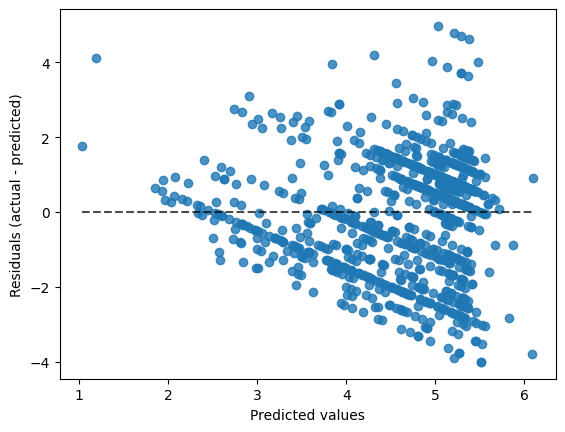

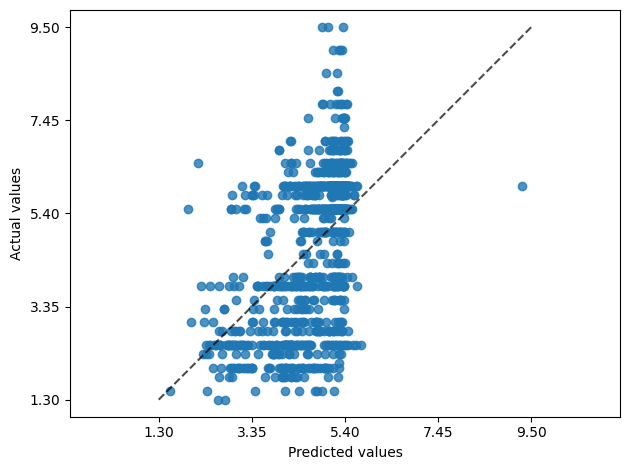

In [12]:
ridgeLinear = linear_model.Ridge(alpha=12)
pipe = make_pipeline(processor, ridgeLinear)
cv_res = cross_validate(estimator=pipe, X=X, y=y, cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
results.append(['Linear regression', mae, r2])
pred = cross_val_predict(ridgeLinear, X, y, cv=10)
PredictionErrorDisplay.from_predictions(y,pred, kind = "residual_vs_predicted")
PredictionErrorDisplay.from_predictions(y,pred, kind = "actual_vs_predicted")
plt.tight_layout()
plt.show()

1.093800691579237 0.16246272256406846


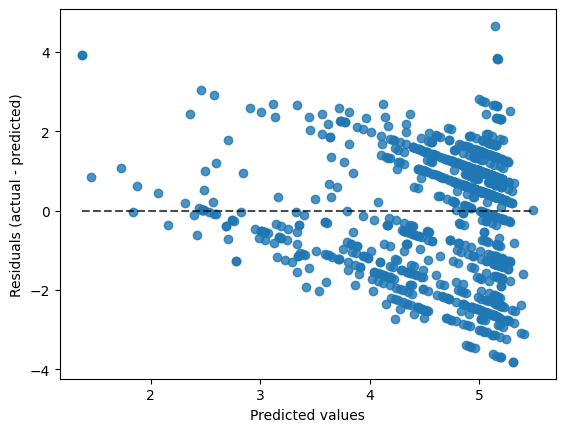

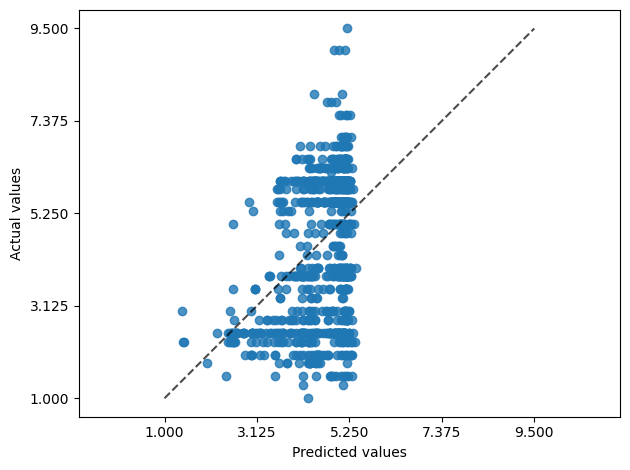

In [13]:
lassoLinear = linear_model.Lasso(alpha = 0.1)
pipe = make_pipeline(processor, ridgeLinear)
cv_res = cross_validate(estimator = pipe, X=X, y=y, cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
results.append(['Lasso regression', mae, r2])
pred = cross_val_predict(lassoLinear, X, y, cv=10)
PredictionErrorDisplay.from_predictions(y,pred, kind = "residual_vs_predicted")
PredictionErrorDisplay.from_predictions(y,pred, kind = "actual_vs_predicted")
plt.tight_layout()
plt.show()

1.0928066694651797 0.1594926668084511


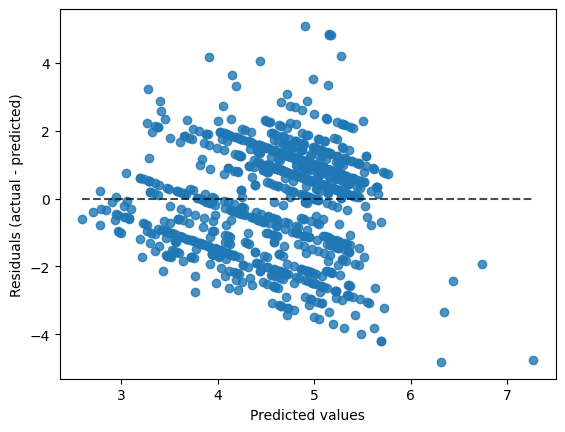

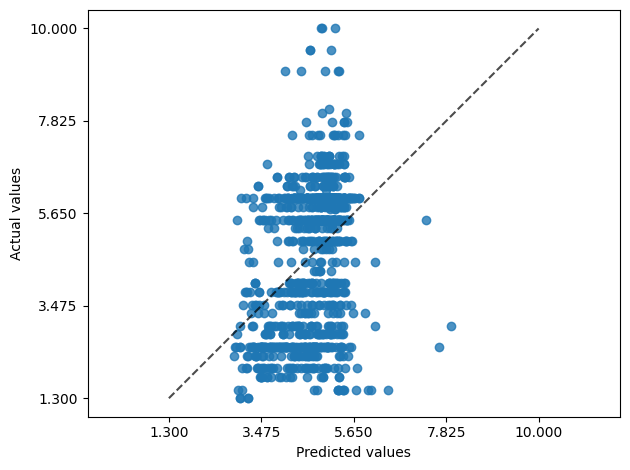

In [14]:
#more then 10k smaples, acording to sklearn guide we can use SGDRegressor
sgdr = linear_model.SGDRegressor(penalty='elasticnet', random_state=7)
pipe = make_pipeline(processor, sgdr)
cv_res = cross_validate(estimator = pipe, X=X, y=y, cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
results.append(['SGD regressor regression', mae, r2])
pred = cross_val_predict(pipe, X, y, cv=10)
PredictionErrorDisplay.from_predictions(y,pred, kind = "residual_vs_predicted")
PredictionErrorDisplay.from_predictions(y,pred, kind = "actual_vs_predicted")
plt.tight_layout()
plt.show()

0.6661282882340583 0.35524639239461014


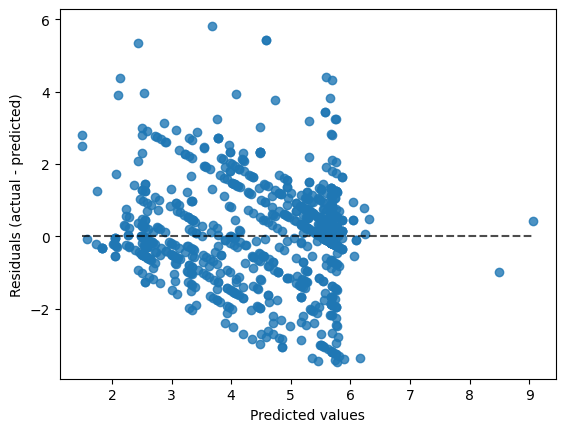

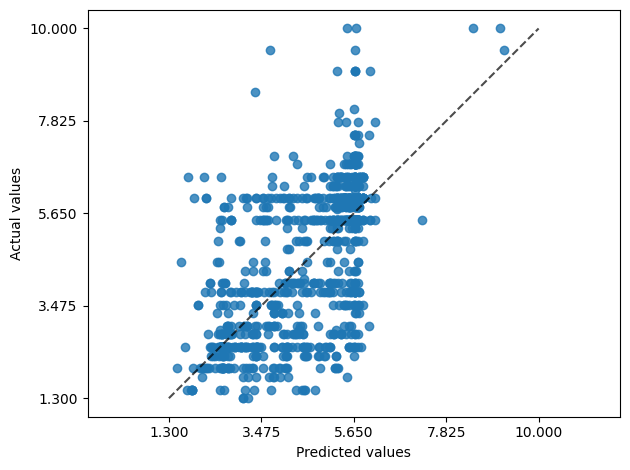

In [15]:
dtr = DecisionTreeRegressor(max_depth=8, random_state=7)
pipe = make_pipeline(processor, dtr)
cv_res = cross_validate(pipe, X=X, y=y,cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
results.append(['DecisionTreeRegressor', mae, r2])
print(mae, r2)
pred = cross_val_predict(pipe, X, y, cv=10)
PredictionErrorDisplay.from_predictions(y,pred, kind = "residual_vs_predicted")
PredictionErrorDisplay.from_predictions(y,pred, kind = "actual_vs_predicted")
plt.tight_layout()
plt.show()

In [16]:
rfr = RandomForestRegressor(max_depth = 8, random_state = 7)
pipe = make_pipeline(processor, rfr)
cv_res = cross_validate(pipe, X=X, y=y,cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
results.append(['randomForestReg', mae, r2])
print(mae, r2)

0.682896178218984 0.44888672195212065


HGBR
"HGBT almost always offers a more favorable speed-accuracy trade-off than RF. There is one exception to this rule of thumb though: when training a multiclass classification model with a large number of possible classes, HGBDT fits internally one-tree per class at each boosting iteration while the trees used by the RF models are naturally multiclass which should improve the speed accuracy trade-off of the RF models in this case."

In [17]:
HGBR = HistGradientBoostingRegressor()
HGBR.get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'quantile': None,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [18]:
pipe = make_pipeline(processor, HGBR)



params = {
        "max_depth" : [12,13,14,15,None],
          "max_leaf_nodes": [95,100,105,110],
          "min_samples_leaf": [40,50,60],
         "loss" : ["absolute_error"]
         }
search = RandomizedSearchCV(pipe[1],params, scoring='neg_median_absolute_error',cv=skf,random_state = 7, n_jobs = -1)
#search = GridSearchCV(pipe[1], params, n_jobs = -1, cv = skf, scoring = "neg_median_absolute_error")
search.fit(X_train, y_train)
print(search.best_params_, search.best_score_)


{'min_samples_leaf': 40, 'max_leaf_nodes': 105, 'max_depth': 14, 'loss': 'absolute_error'} -0.5257985871136008


0.5258607550799244 0.4492494518017095


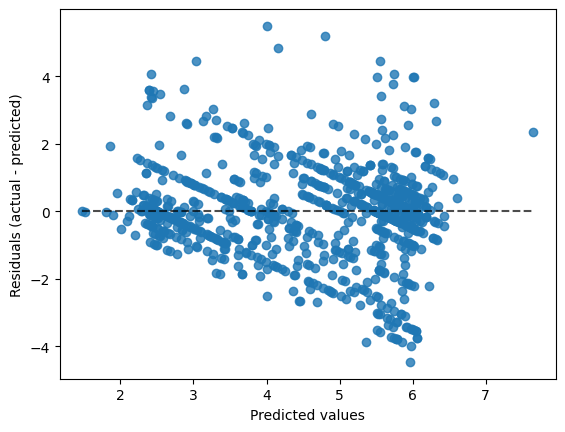

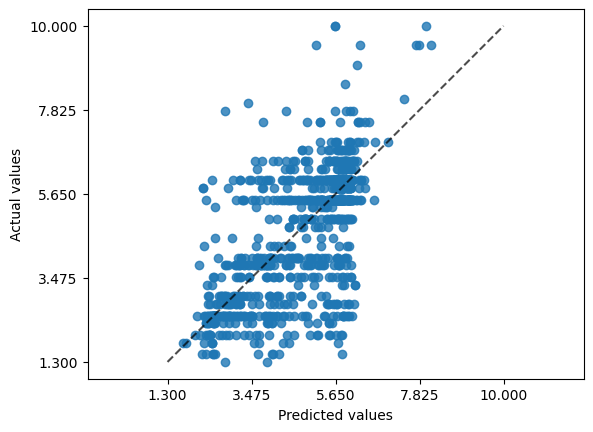

In [19]:
pipe[1].set_params(**search.best_params_)
cv_res = cross_validate(pipe, X=X, y=y,cv=skf, scoring = ['neg_median_absolute_error', 'r2'])
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
pred = cross_val_predict(pipe, X, y, cv=10)
PredictionErrorDisplay.from_predictions(y,pred, kind = "residual_vs_predicted")
PredictionErrorDisplay.from_predictions(y,pred, kind = "actual_vs_predicted")
results.append(["HGBR", mae, r2])

In [20]:
xgb = XGBRegressor(objective = 'reg:absoluteerror')
pipe = make_pipeline(processor, xgb)
cv_res = cross_validate(pipe, X=X, y=y,cv=skf, scoring = ['neg_median_absolute_error', 'r2'], n_jobs = -1)
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
results.append(["XGBreg", mae, r2])

0.5585421752929687 0.4247741185521079


0.5292374884214976 0.4437427132427797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 9366, number of used features: 10
[LightGBM] [Info] Start training from score 5.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 9366, number of used features: 10
[LightGBM] [Info] Start training from score 5.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 9366, number of used featu

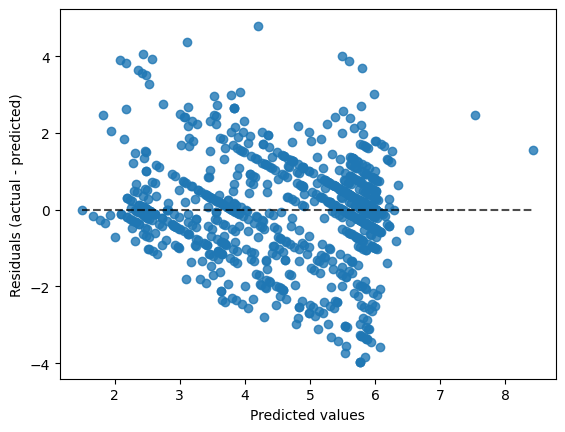

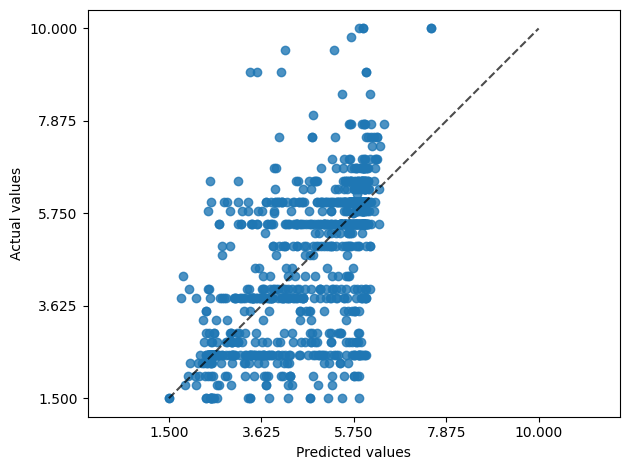

In [21]:
lgbm = LGBMRegressor(objective = 'mae')
pipe = make_pipeline(processor, lgbm)
cv_res = cross_validate(pipe, X=X, y=y,cv=skf, scoring = ['neg_median_absolute_error', 'r2'], n_jobs = -1)
mae = -cv_res['test_neg_median_absolute_error'].mean()
r2 = cv_res['test_r2'].mean()
print(mae, r2)
results.append(["LGMR", mae, r2])
pred = cross_val_predict(pipe, X, y, cv=10)
PredictionErrorDisplay.from_predictions(y,pred, kind = "residual_vs_predicted")
PredictionErrorDisplay.from_predictions(y,pred, kind = "actual_vs_predicted")
plt.tight_layout()
plt.show()

In [22]:
md1 = make_pipeline(PowerTransformer(), HGBR)
md1[1].set_params(**search.best_params_)

md2 = make_pipeline(PowerTransformer(), lgbm)

md3 = make_pipeline(PowerTransformer(), xgb)
dtr = DecisionTreeRegressor(max_depth=8, random_state=7)
md4 = make_pipeline(PowerTransformer(), dtr)


stacker = StackingRegressor(estimators=[('HGBR', md1),('LGBM', md2),('XGB', md3),('DTR', md4)], n_jobs=-1, final_estimator=linear_model.LinearRegression(), cv=skf)
stacker.fit(X_train, y_train)
pred = stacker.predict(X_test)
stacker_score = median_absolute_error(y_test, pred)
stacker_score
results.append(["stacker", stacker_score, r2_score(y_test, pred)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2306
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 10
[LightGBM] [Info] Start training from score 5.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 7492, number of used features: 10
[LightGBM] [Info] Start training from score 5.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in the train set: 7492, number of used features: 10
[LightGBM] [Info] Start traini

In [23]:
results = sorted(results, key = lambda x:x[1])
df = pd.DataFrame(results, columns =['Model', 'mse', 'r2'], index=None)
print(df)

                      Model       mse        r2
0                      HGBR  0.525861  0.449249
1                      LGMR  0.529237  0.443743
2                    XGBreg  0.558542  0.424774
3                   stacker  0.583788  0.442735
4     DecisionTreeRegressor  0.666128  0.355246
5           randomForestReg  0.682896  0.448887
6         Linear regression  1.092801  0.162449
7  SGD regressor regression  1.092807  0.159493
8         Linear regression  1.093801  0.162463
9          Lasso regression  1.093801  0.162463


# Final prediction

In [24]:
pipe = make_pipeline(processor, HGBR)
pipe[1].set_params(**search.best_params_)
pipe.fit(X, y)
X_test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")
y_pred = pipe.predict(X_test.drop('id', axis=1))

In [25]:
submission = pd.DataFrame(X_test['id'], columns=["id"])

In [26]:
submission['Hardness'] = pd.DataFrame(y_pred, columns=['Hardness'])
submission

,id,Hardness
0,10407,2.502578
1,10408,2.566714
2,10409,6.037331
3,10410,4.180495
4,10411,5.403653
...,...,...
6934,17341,5.983838
6935,17342,4.002450
6936,17343,5.376756
6937,17344,4.783177


In [27]:
submission.to_csv("submission.csv", index=False)